In [1]:
!pip install basemap
!pip install basemap-data
!pip install folium
!pip install osmnx

In [2]:
import pandas as pd
import regex as re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
import seaborn as sns
import osmnx as ox
from sklearn.cluster import KMeans as KMeans
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap


Starting to construct the Network


In [10]:
categories_dict = {'0': 'River', '1': 'Body of Water', '2': 'Large Aquaduct', '3': 'Data Station', '4': 'Corner', '5': 'End of line', '6': 'Marina', '7': 'Agriculture pond', '8': 'Inlet, contains islands', '9': 'Canal', '10': 'Creek', '11': 'Barge stop', '12': 'Small Aquaduct', '13': 'Agriculture Creek', '14': 'Bay', '15': 'Slough', '16': 'Transition Length(from diff size flows)', '17':'Ocean'}
colors_dict = {'0' : 'red', '1': 'orange', '2': 'yellow', '3':'olive', '4':'brown', '5':'black', '6':'gray', '7':'limegreen', '8':'green', '9': 'purple', '10': 'pink', '11':'cyan', '12':'navy', '13': 'fuchsia', '14': 'mediumvioletred', '15':'darkcyan', '16':'peachpuff', '17': 'indigo'}
print('Categories are:', categories_dict.values())

Categories are: dict_values(['River', 'Body of Water', 'Large Aquaduct', 'Data Station', 'Corner', 'End of line', 'Marina', 'Agriculture pond', 'Inlet, contains islands', 'Canal', 'Creek', 'Barge stop', 'Small Aquaduct', 'Agriculture Creek', 'Bay', 'Slough', 'Transition Length(from diff size flows)', 'Ocean'])


In [4]:
River_df = pd.read_csv('RiverNetwork.csv')
River_df.columns=River_df.iloc[0]
River_df = River_df.loc[1:]
River_df = River_df.set_index("NodeID")
River_df['Latitude(North)'] = River_df['Latitude(North)'].astype(float)
River_df['Longitude(West)'] = River_df['Longitude(West)'].astype(float)
River_df['Lat,Long'] = [(River_df['Longitude(West)'][i], River_df['Latitude(North)'][i]) for i in range(len(River_df))]
River_df['Neighbors'] = [np.array(River_df['Neighbors'][i]) for i in range(len(River_df))]

In [5]:
River_df['Neighbors'][0]

array('[2, 3]', dtype='<U6')

In [6]:
print('The range of latitudes are:', max(River_df['Latitude(North)']) - min(River_df['Latitude(North)']))
print('The range of longitudes are:', max(River_df['Longitude(West)']) - min(River_df['Longitude(West)']))

The range of latitudes are: 0.7890985000000015
The range of longitudes are: 1.2106205000000045


In [7]:
### This will ensure that neighbors of nodes are arrays of (Numbers or Strings) as opposed to a string that looks like array
Neighbors_column = []
Neighbors_count_column = []
for i in range(0, 102):
    node_nbors = [int(num) for num in re.findall(r'\b\d+\b', str(River_df['Neighbors'][i]))]
    node_nbors_count = len(node_nbors)
    Neighbors_column.append(node_nbors)
    Neighbors_count_column.append(node_nbors_count)
River_df['Neighbors'] = Neighbors_column
River_df.head(5)

,NaN,Latitude(North),Longitude(West),Neighbors,Category,Name:,Other Categories:,"Lat,Long"
NodeID,,,,,,,,
1,NaN,38.570258,-121.511848,"[2, 3]",0,Sacramento River,NaN,"(-121.5118481, 38.5702579)"
2,NaN,38.560765,-121.516698,"[1, 3]",6,Sacramento marina,NaN,"(-121.5166983, 38.56076507)"
3,NaN,38.561169,-121.523916,"[2, 1]",9,Barge Canal 1,NaN,"(-121.5239158, 38.5611691)"
4,NaN,38.562139,-121.549840,"[3, 5]",11,Barge Stop 2,NaN,"(-121.5498401, 38.5621388)"
5,NaN,38.358281,-121.637045,"[4, 6, 7]",2,SacTown Aqueduct,NaN,"(-121.6370446, 38.3582813)"


Text(0, 0.5, 'Latitude(North)')

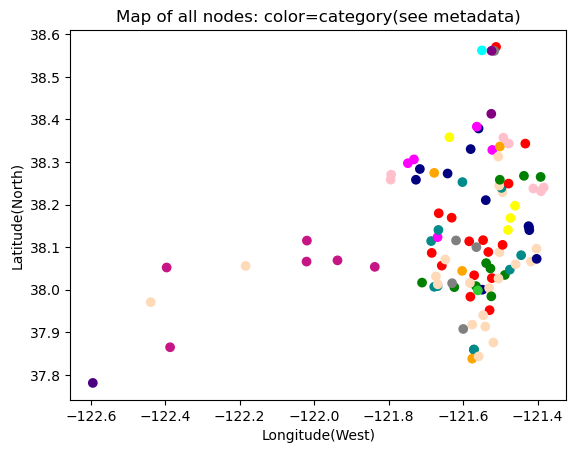

In [12]:
### I am looking to plot these points on plot hopefully they will be properly scattered
plt.scatter(River_df['Longitude(West)'],River_df['Latitude(North)'], c = River_df['Category'].map(colors_dict))
plt.title('Map of all nodes: color=category(see metadata)')
plt.xlabel('Longitude(West)')
plt.ylabel('Latitude(North)')


In [13]:
### I will now create a network given the data
River_System = nx.Graph()
for nodeID in range(1, 101):
    connections = []
    for neighbor in River_df['Neighbors'][nodeID-1]:
        connections.append((nodeID, neighbor))
    River_System.add_edges_from(connections)

In [14]:
###Simple statistics
print('The average Clustering Coefficient of our graph is:',nx.average_clustering(River_System))
print('The number of nodes we have is:', River_System.number_of_nodes())
print('The numnber of edges we have is:', River_System.number_of_edges())
print('The average degree is:', np.mean(list(dict(River_System.degree()).values())))
print('The average shortest path is:', nx.average_shortest_path_length(River_System))
print('The Max degree is:', max(dict(River_System.degree()).values()), "and the node with this degree is: San Joaquin River")
print('The Min degree is:', min(dict(River_System.degree()).values()))

The average Clustering Coefficient of our graph is: 0.21992745816275225
The number of nodes we have is: 102
The numnber of edges we have is: 146
The average degree is: 2.8627450980392157
The average shortest path is: 6.149873810910503
The Max degree is: 13 and the node with this degree is: San Joaquin River
The Min degree is: 1


In [15]:
#Calculating the information for a row of the table.
def calc_info(graph):
  CC = nx.average_clustering(graph)
  avg_deg = np.mean(list(dict(graph.degree()).values()))
  shortpath = nx.average_shortest_path_length(graph)
  num_nodes = nx.number_of_nodes(graph)
  num_links = nx.number_of_edges(graph)
  return [CC, avg_deg, shortpath, num_nodes, num_links]
#Insert and item in a specific row and colomn of a data frame
def insert_item(column, row, item, df):
  df.at[row, column] =  item

#insert a full row in a data frame
def insert_row(columns, row, info, df):
  input_columns = columns[1:]
  for  i, column in enumerate(input_columns):
    insert_item(column, row, info[i], df)
    
#Create a function to form the graphs:
def create_graph(type_graph, p_connect, num_nodes, p_shuffle, k, kmin):
  if type_graph == 'rand':
      return nx.erdos_renyi_graph(num_nodes, p_connect)
  elif type_graph == 'watts':
      return nx.watts_strogatz_graph(num_nodes, k, p_shuffle)
  else:
      return nx.barabasi_albert_graph(num_nodes, kmin)

#Create a function that will take in empty dataframes and create a filled in table as the one on the homework shows!!
def createNfill_table(graphs, graph_names):
  df = pd.DataFrame()
  df['Network'] = [graph_names[0], graph_names[1], graph_names[2], graph_names[3]]
  df['Average Clustering Coeff'] = np.zeros(4)
  df['Average Degrees'] = np.zeros(4)
  df['Average Shortest Path'] = np.zeros(4)
  df['Num Nodes'] = np.zeros(4)
  df['Num Links'] = np.zeros(4)
  for row_index, graph in enumerate(graphs):
    print('graph index:', row_index)
    input_info = calc_info(graph)
    columns = df.columns
    insert_row(columns, row_index, input_info, df)
  return df

#Creating all the graph names for our table, the network Row
def create_graph_names(vals, rand):
  graph_names = []
  if rand == True:
    graph_names.append('River Network')
  else:
    graph_names.append('River Network')
  graph_names.append(str('Random Graph Model (p=' + str(vals[0]) + ', N=' + str(vals[1]) + ')'))
  graph_names.append('Small World Model (p,k,n)(p={}, N={} ,k={})'.format(vals[2], vals[1], vals[3]))
  graph_names.append('Barabasi Albert Model (N={}, Kmin={})'.format(vals[1], vals[4]))
  return graph_names

#Creates arrays for the degree distribution of each graph
def create_hists(graph_array, graph_names):
  for i, graph in enumerate(graph_array):
    degree_arr = []
    for node in graph.nodes:
      degree_arr.append(nx.degree(graph, node))
    plt.hist(degree_arr, bins = 10, density = True)
    plt.xlabel('Degree of nodes')
    plt.ylabel('percent of nodes with degree___')
    plt.title(graph_names[i])
    plt.show()

In [16]:
C0 = nx.average_clustering(nx.watts_strogatz_graph(102, 4, 0))
Cp = C0*(1-.15)**3
prob_reshuffle = 1 - pow(Cp/C0, 1/3)
random_p = .2
num_nodes = 102
num_connections = 3
min_connections = 3
rand_vals = [random_p, num_nodes, prob_reshuffle, num_connections, min_connections]


random_model = create_graph('rand', *rand_vals)
small_world_model = create_graph('watts', *rand_vals)
brabasi_model = create_graph('barb', *rand_vals)

rand_graph_names = create_graph_names(rand_vals, rand=True)
rand_graphs = [River_System, random_model, small_world_model, brabasi_model]

In [17]:
createNfill_table(rand_graphs, rand_graph_names)

graph index: 0
graph index: 1
graph index: 2


NetworkXError: Graph is not connected.

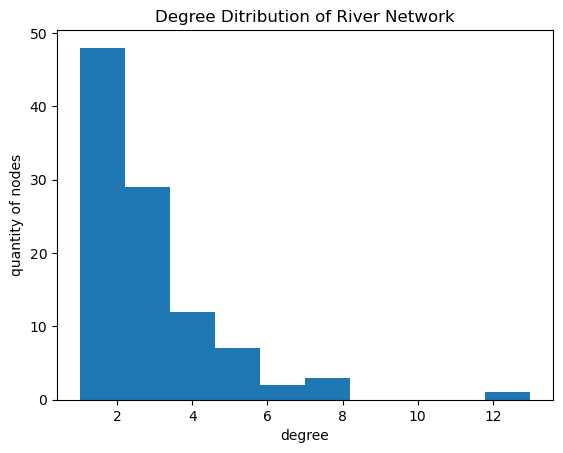

In [18]:
###plot the degree distribution
plt.hist(dict(River_System.degree).values())
plt.title('Degree Ditribution of River Network')
plt.xlabel('degree')
plt.ylabel('quantity of nodes')
plt.show()

Text(0.5, 1.0, 'River Network Visualized')

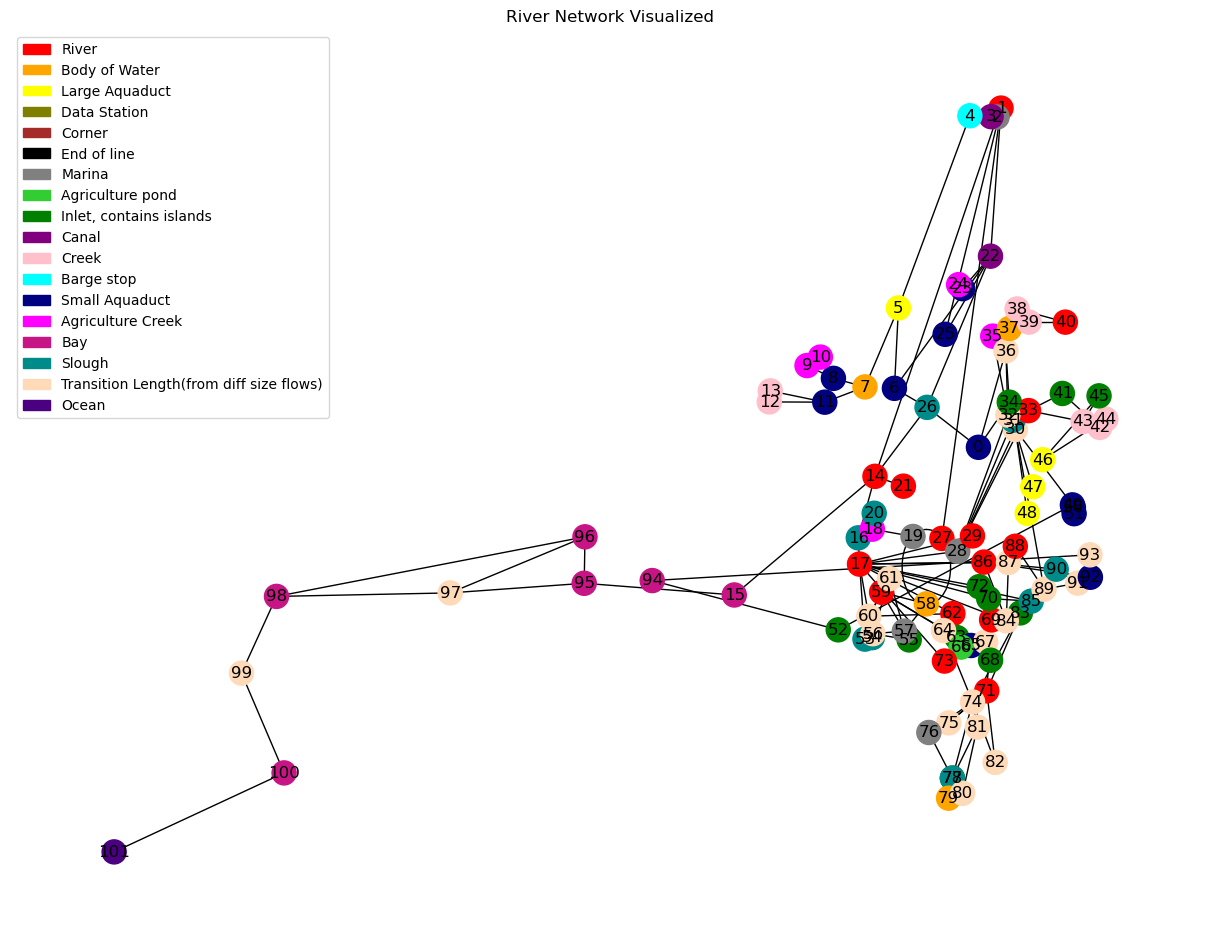

In [20]:
###Draw the network based on locatoin and colors
positions = dict(zip(River_System.nodes, River_df['Lat,Long']))
plt.figure(figsize=(12, 9))
nx.draw(River_System, positions, node_color = River_df['Category'].map(colors_dict), with_labels = True)
handels = []
for i in categories_dict.keys():
    handels.append(mpatches.Patch(color = colors_dict.get(i), label = categories_dict.get(i)))


plt.legend(handles = handels)

plt.title('River Network Visualized')

In [21]:
River_df['Node Degree'] = dict(River_System.degree()).values()
print('note the Neighbors Count column is false since it is an undirected system, it does not count mutual neighbors in the count...')




note the Neighbors Count column is false since it is an undirected system, it does not count mutual neighbors in the count...


In [22]:
### Create a list of all the hubs!!!!!
hubs_dict = {}
hubs_list = []
for i in range(len(River_df['Category'])):
    if River_df['Node Degree'][i] >= 6:
        hubs_dict[River_df.index[i]] = River_df['Node Degree'][i]
        hub = np.array(River_df.index)[i]
        hubs_list.append(River_df.index[i])
print(hubs_list)

['17', '29', '31', '33', '34', '75']


In [23]:
print('The "hubs" of our system are: ', [River_df['Name:'][i] for i in hubs_list])
hubs_df = River_df[River_df.index.isin(hubs_list)]

The "hubs" of our system are:  ['San Joaquin River', 'Pirates lair marina', 'Dead Horse Cut', 'Mokelume River', 'Delta Cross Channel', 'Old/Middle Connector']


In [24]:
hubs_df

,NaN,Latitude(North),Longitude(West),Neighbors,Category,Name:,Other Categories:,"Lat,Long",Node Degree
NodeID,,,,,,,,,
17,NaN,38.086492,-121.684571,[16],0,San Joaquin River,NaN,"(-121.6845708, 38.0864916)",13
29,NaN,38.100052,-121.564690,"[17, 28]",6,Pirates lair marina,NaN,"(-121.5646898, 38.1000518)",7
31,NaN,38.229293,-121.494266,"[30, 32, 28, 33]",16,Dead Horse Cut,NaN,"(-121.4942657, 38.2292931)",7
33,NaN,38.249310,-121.478266,"[28, 30, 31]",0,Mokelume River,NaN,"(-121.4782663, 38.2493101)",6
34,NaN,38.244591,-121.503439,"[32, 0]",16,Delta Cross Channel,NaN,"(-121.5034386, 38.2445909)",6
75,NaN,37.940179,-121.546559,"[74, 71]",16,Old/Middle Connector,NaN,"(-121.5465585, 37.9401786)",7


Note: Red = San Joaquin River, Blue = Pirates lair marina, Green = Dead Horse Cut, Organe = Mokelume River, Purple = Delta Cross Channel, Black = Old/Middle Connector


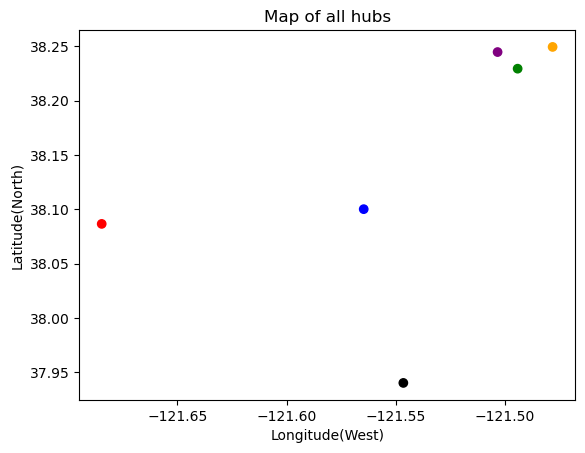

In [25]:
print('Note: Red = San Joaquin River, Blue = Pirates lair marina, Green = Dead Horse Cut, Organe = Mokelume River, Purple = Delta Cross Channel, Black = Old/Middle Connector')
plt.scatter(hubs_df['Longitude(West)'],hubs_df['Latitude(North)'], c = ['red', 'blue', 'green', 'orange', 'purple', 'black'])
plt.title(f'Map of all hubs')
plt.xlabel('Longitude(West)')
plt.ylabel('Latitude(North)')
plt.show()


In [26]:
### Play around with PYVIS, very similar to Gephi as a new way to visualize networks. I am just beginnging but like what I see.
! pip install pyvis

In [27]:
from pyvis.network import Network

In [28]:
River_network = Network(notebook = True)
River_network.from_nx(River_System)
River_network.show_buttons(filter_ = ['nodes'])
River_network.show('RiverNetwork.html')

RiverNetwork.html


In [29]:
### Start looking at betweenness of our river network

betweenness = nx.centrality.betweenness_centrality(River_System)
River_df['betweenness'] = betweenness.values()
max_between = max(betweenness.values())
print('The node with the max betweenness is shown below')
River_df[River_df['betweenness'] == max_between]

The node with the max betweenness is shown below


,NaN,Latitude(North),Longitude(West),Neighbors,Category,Name:,Other Categories:,"Lat,Long",Node Degree,betweenness
NodeID,,,,,,,,,,
17,NaN,38.086492,-121.684571,[16],0,San Joaquin River,NaN,"(-121.6845708, 38.0864916)",13,0.587347


Text(0.5, 1.0, 'River System Drawn with degree centrality for size')

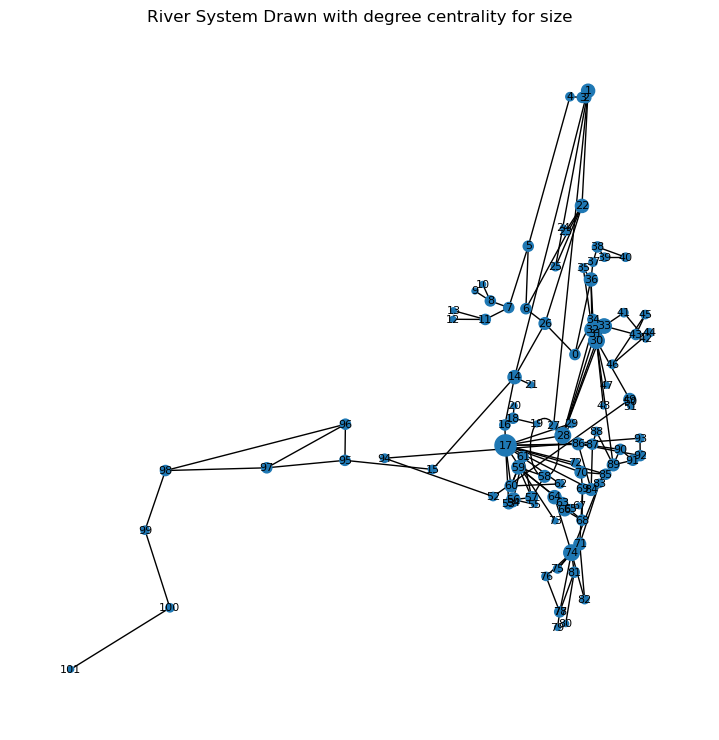

In [30]:
###Degree centrality analysis
degree_centrality = nx.degree_centrality(River_System)
plt.figure(2, figsize=(7,7))
coord = nx.spring_layout(River_System)
nx.draw(River_System, positions, node_size = [d*1800 for d in degree_centrality.values()],
         font_size = 8, with_labels = True)
plt.title("River System Drawn with degree centrality for size")

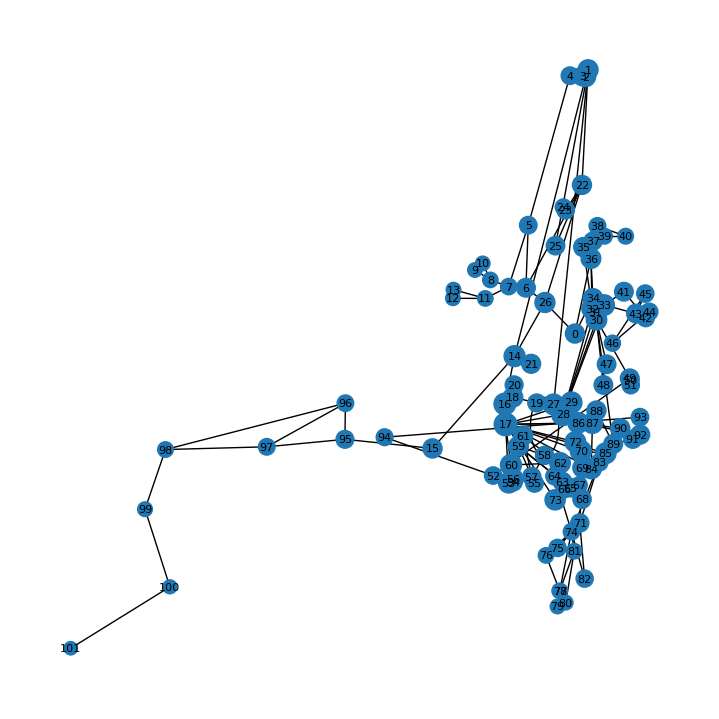

In [31]:
closeness_centrality = nx.closeness_centrality(River_System)
plt.figure(1, figsize=(7,7))
coord = nx.spring_layout(River_System)
nx.draw(River_System, positions, node_size = [d*1000 for d in closeness_centrality.values()],
         font_size = 8, with_labels = True)

In [33]:
River_df['degree_centrality'] = degree_centrality.values()
River_df['closeness_centrality'] = closeness_centrality.values()

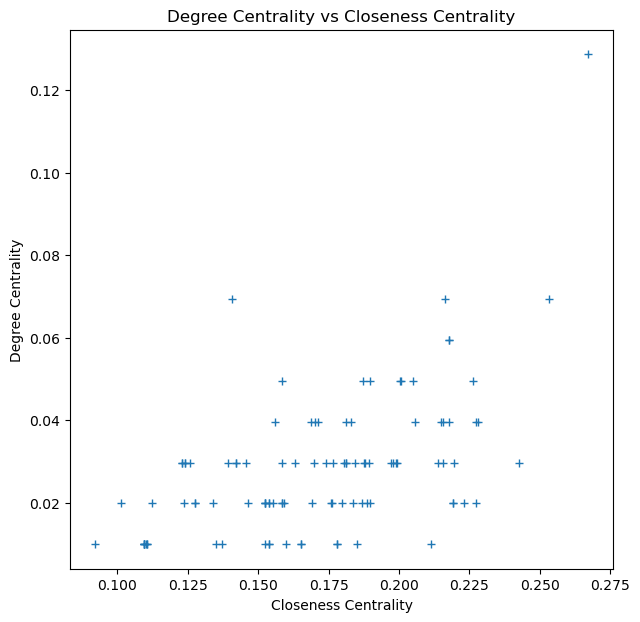

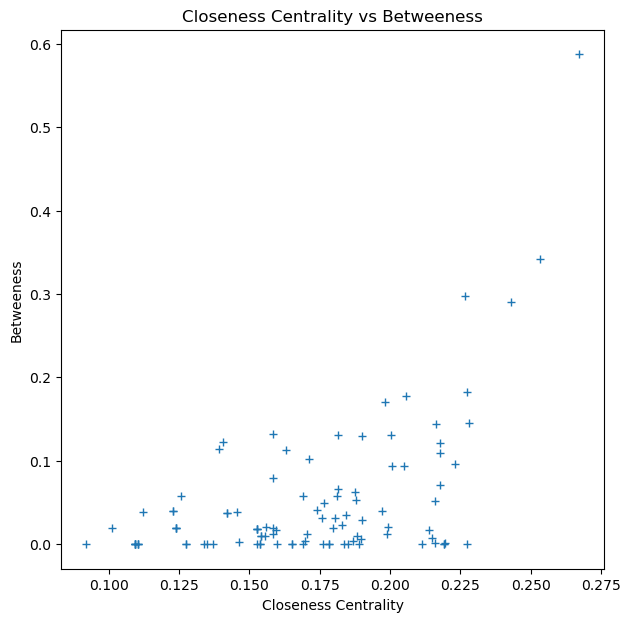

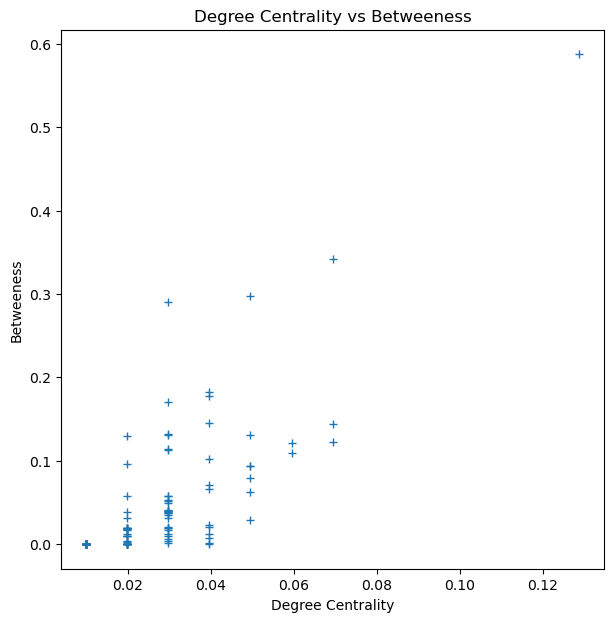

C:\Users\Tyler Marino\AppData\Local\Temp\ipykernel_51532\1654122322.py:28: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


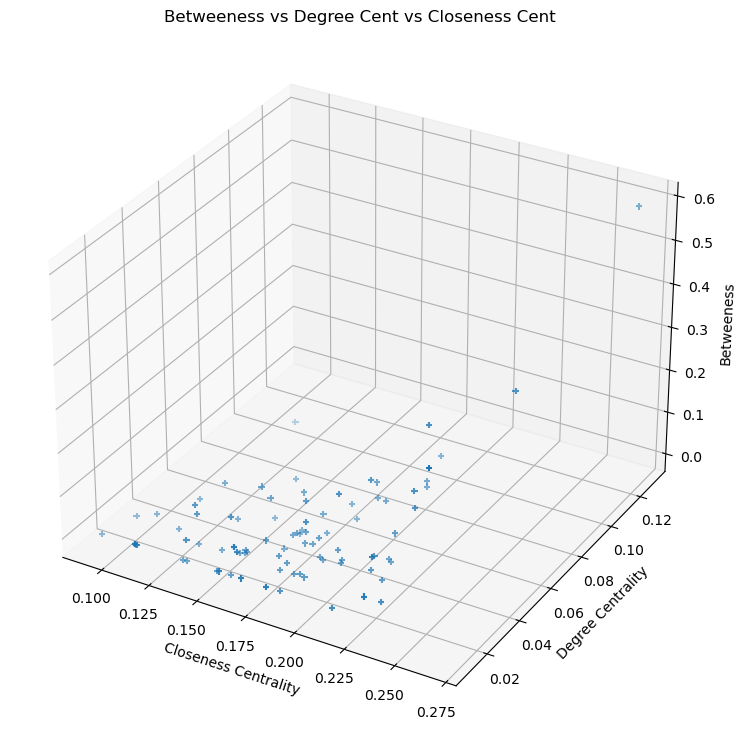

In [34]:
xdata = River_df['closeness_centrality']
ydata = River_df['degree_centrality']
zdata = River_df['betweenness']

plt.figure(1, figsize=(7, 7))
plt.plot(xdata,ydata, '+')
plt.xlabel('Closeness Centrality')
plt.ylabel('Degree Centrality')
plt.title('Degree Centrality vs Closeness Centrality')
plt.show()

plt.figure(1, figsize=(7, 7))
plt.plot(xdata,zdata, '+')
plt.xlabel('Closeness Centrality')
plt.ylabel('Betweeness')
plt.title('Closeness Centrality vs Betweeness')
plt.show()


plt.figure(1, figsize=(7, 7))
plt.plot(ydata,zdata, '+')
plt.xlabel('Degree Centrality')
plt.ylabel('Betweeness')
plt.title('Degree Centrality vs Betweeness')
plt.show()

fig = plt.figure(2, figsize=(7,7))
ax = Axes3D(fig)
ax.scatter(xdata, ydata, zdata, marker = '+')
ax.set_xlabel('Closeness Centrality')
ax.set_ylabel('Degree Centrality')
ax.set_zlabel('Betweeness')
ax.set_title('Betweeness vs Degree Cent vs Closeness Cent')
plt.show()

In [35]:
### This cell will define a function that will allow for dataframes to be created that have only one type of water feature
def separate_dfs_by_category(df):
    dfs_by_category = []
    for i in range(18):
        df_to_playwith = df.copy()
        df_to_playwith['Category'] = df_to_playwith['Category'].astype(int)
        df_to_playwith = df_to_playwith[df_to_playwith['Category'] == i]
        dfs_by_category.append(df_to_playwith)
    return dfs_by_category

### dfs_by_cat will be big in plotting of different features on maps
dfs_by_cat = separate_dfs_by_category(River_df)

In [36]:
### for information
total_when_sep = 0
for i in range(18):
    category = str(i)
    len_when_sep = len(dfs_by_cat[i]['Category'])
    print('There are ', len_when_sep, ' features of type:', categories_dict.get(category))
    total_when_sep += len_when_sep
print('this leaves us with a total number of features at:', total_when_sep, '!!BINGO!!')

There are  15  features of type: River
There are  4  features of type: Body of Water
There are  4  features of type: Large Aquaduct
There are  0  features of type: Data Station
There are  0  features of type: Corner
There are  0  features of type: End of line
There are  5  features of type: Marina
There are  1  features of type: Agriculture pond
There are  11  features of type: Inlet, contains islands
There are  2  features of type: Canal
There are  7  features of type: Creek
There are  1  features of type: Barge stop
There are  11  features of type: Small Aquaduct
There are  5  features of type: Agriculture Creek
There are  6  features of type: Bay
There are  9  features of type: Slough
There are  20  features of type: Transition Length(from diff size flows)
There are  1  features of type: Ocean
this leaves us with a total number of features at: 102 !!BINGO!!


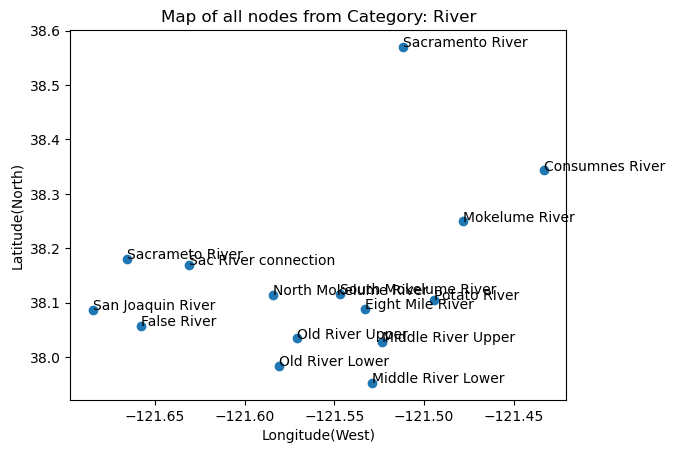

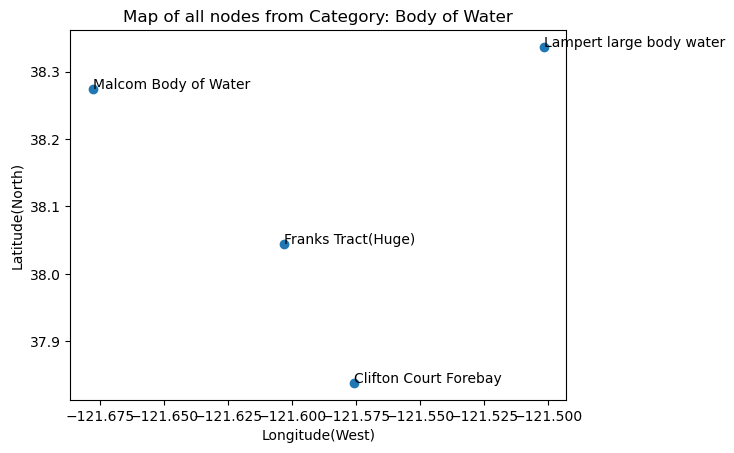

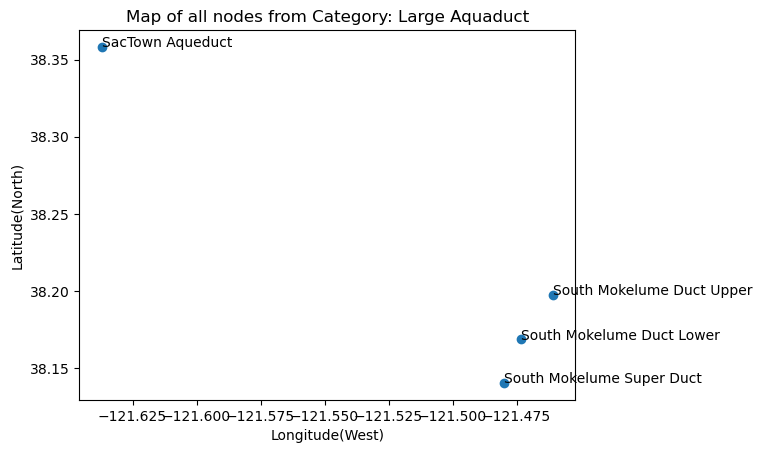

Category 3 has no data
Category 4 has no data
Category 5 has no data


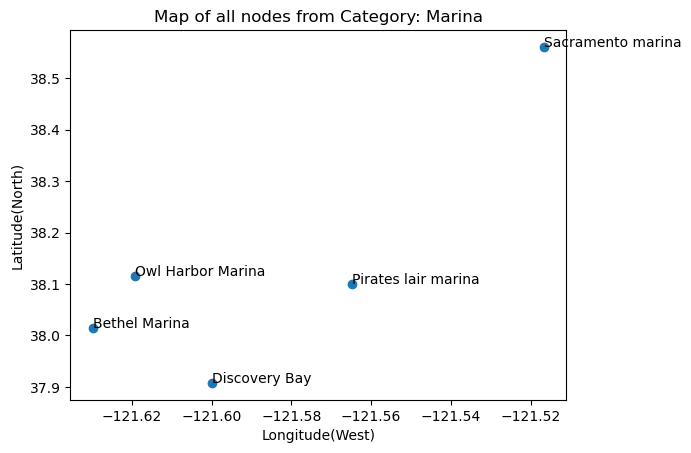

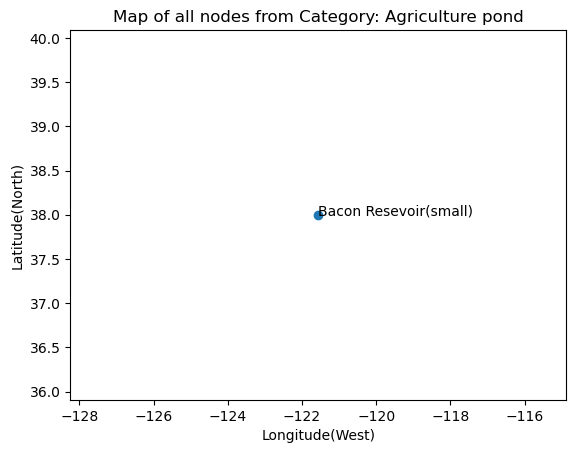

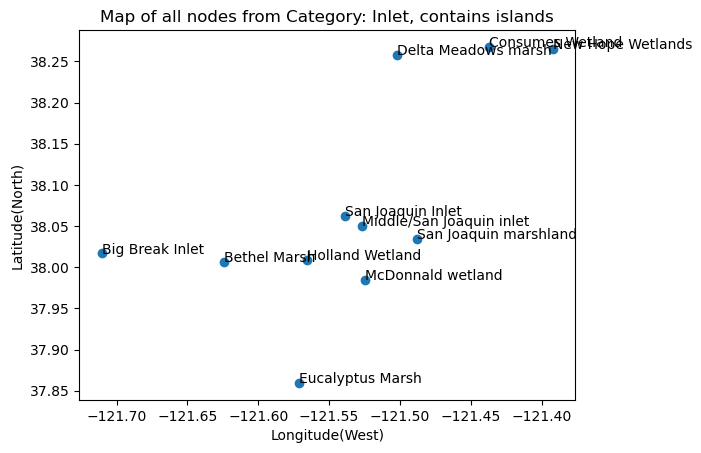

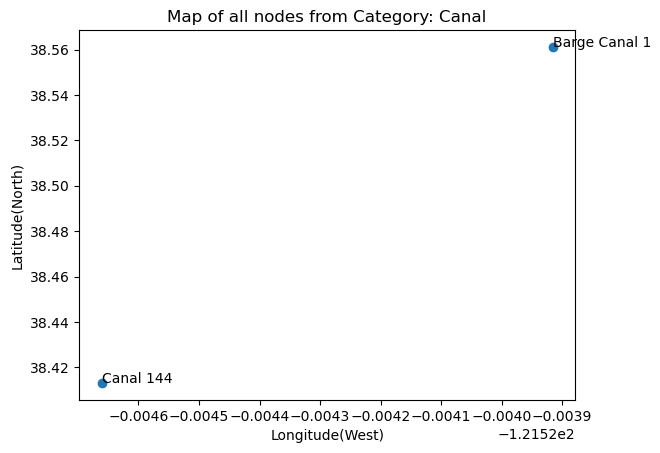

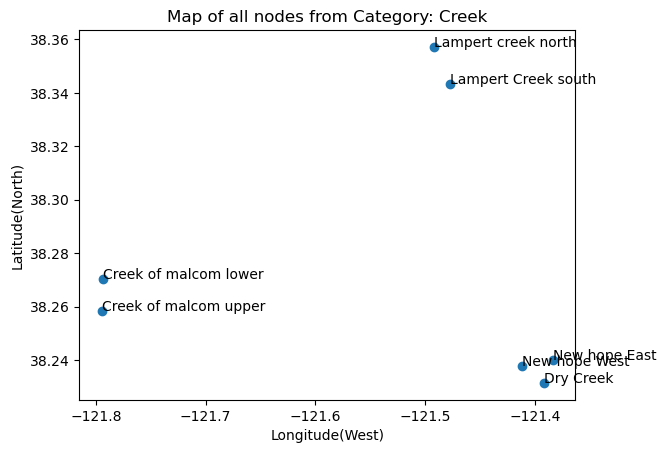

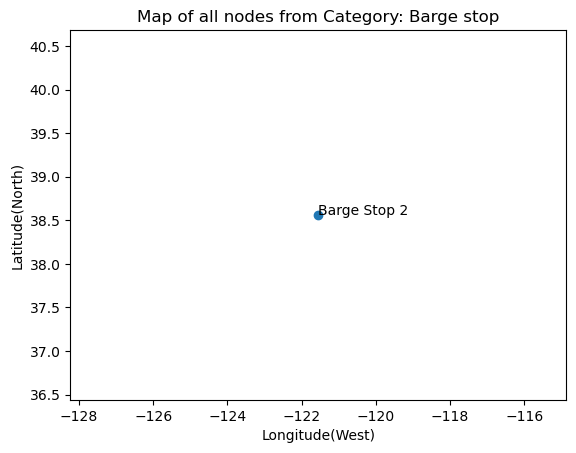

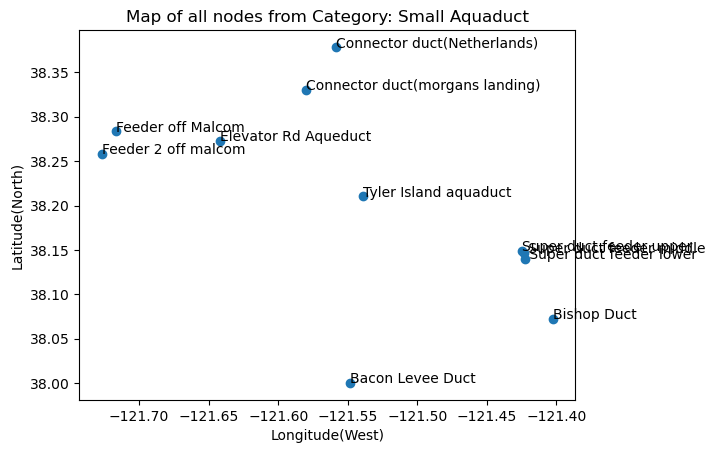

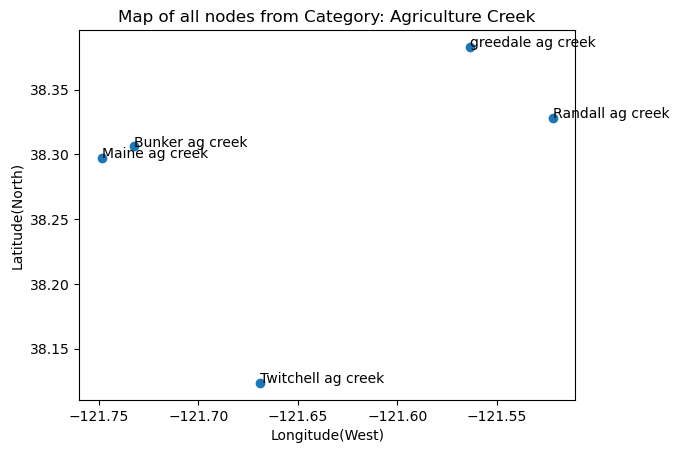

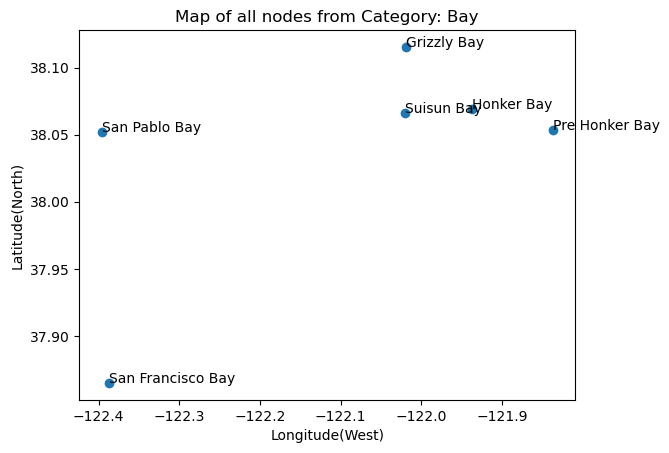

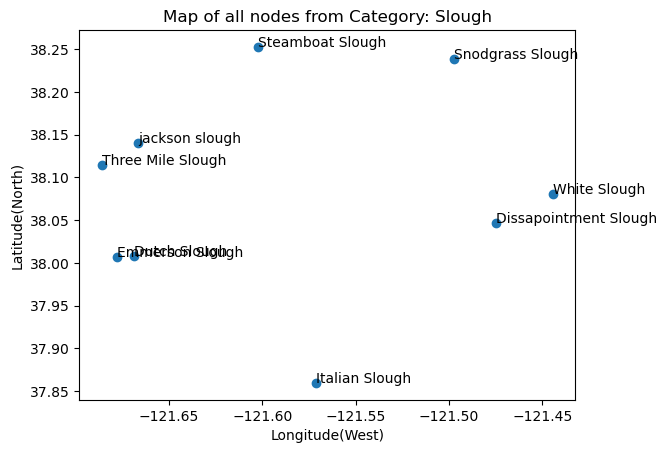

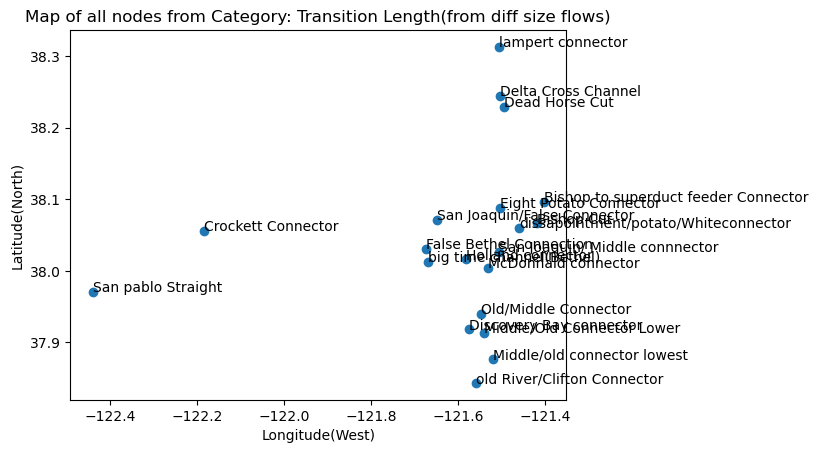

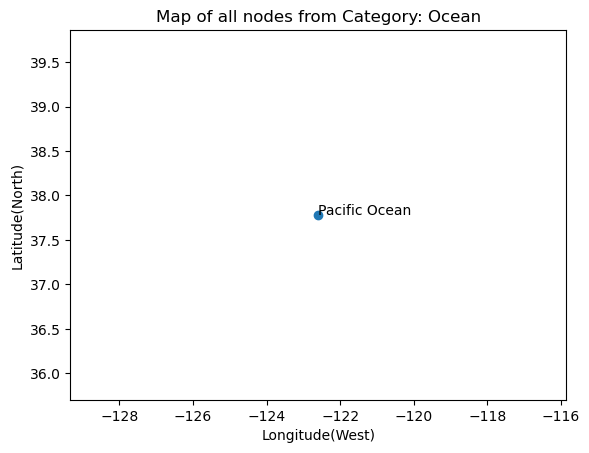

In [37]:
for index,category_df in enumerate(dfs_by_cat):
    if len(category_df) == 0:
        print(f'Category {index} has no data')
    else:
        plt.scatter(category_df['Longitude(West)'],category_df['Latitude(North)'])
        plt.title(f'Map of all nodes from Category: {categories_dict.get(str(index))}')
        plt.xlabel('Longitude(West)')
        plt.ylabel('Latitude(North)')
        for i in range(len(category_df)):
            plt.annotate(category_df["Name:"][i], (category_df['Longitude(West)'][i],category_df['Latitude(North)'][i]))
        plt.show()

In [38]:
#River_df

In [39]:
cluster_sizes = range(2, 8)
River_df_tocluster = River_df[['betweenness', 'closeness_centrality', 'degree_centrality', 'Node Degree']]
inertias = []
kmeans_dict = {}
for size in cluster_sizes:
    kmeans = KMeans(n_clusters = size)
    kmeans = kmeans.fit(River_df_tocluster)
    kmeans_dict[size] = kmeans
    inertia = kmeans.inertia_
    inertias.append(inertia)


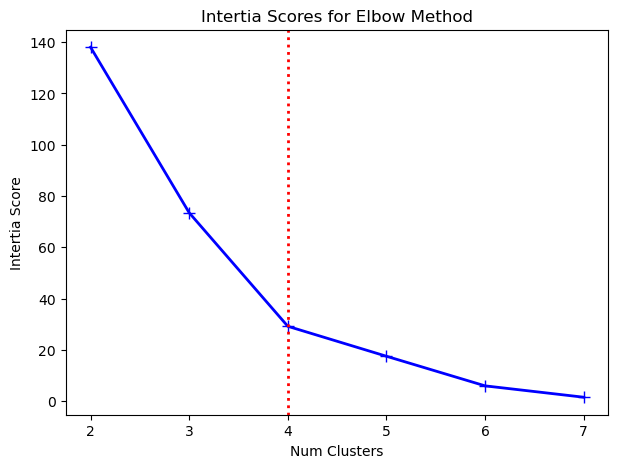

In [40]:
interita_plt = plt.figure(figsize=(7, 5))
inertia_plt = plt.plot(range(2,8), inertias, linewidth = 2, color = 'blue', marker = '+', markersize = 8)
inertia_plt = plt.title('Intertia Scores for Elbow Method')
inertia_plt = plt.xlabel('Num Clusters')
inertia_plt = plt.ylabel('Intertia Score')

num_clusters = 4
interita_plt = plt.axvline(x = num_clusters, linewidth = 2, color = 'red', linestyle = ':')
plt.show()



In [41]:
River_df['Cluster Groupings'] = (kmeans_dict.get(3).labels_ + 1)
River_df_tocluster['Cluster Groupings'] = (kmeans_dict.get(3).labels_ + 1)
River_df_tocluster

C:\Users\Tyler Marino\AppData\Local\Temp\ipykernel_51532\1037930384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  River_df_tocluster['Cluster Groupings'] = (kmeans_dict.get(3).labels_ + 1)


,betweenness,closeness_centrality,degree_centrality,Node Degree,Cluster Groupings
NodeID,,,,,
1,0.093312,0.204868,0.049505,5,2
2,0.020066,0.199211,0.029703,3,2
3,0.030957,0.180357,0.029703,3,2
4,0.016601,0.159306,0.019802,2,3
5,0.132574,0.158307,0.029703,3,2
...,...,...,...,...,...
98,0.038020,0.142053,0.029703,3,2
99,0.058218,0.125622,0.029703,3,2
100,0.039208,0.112222,0.019802,2,3


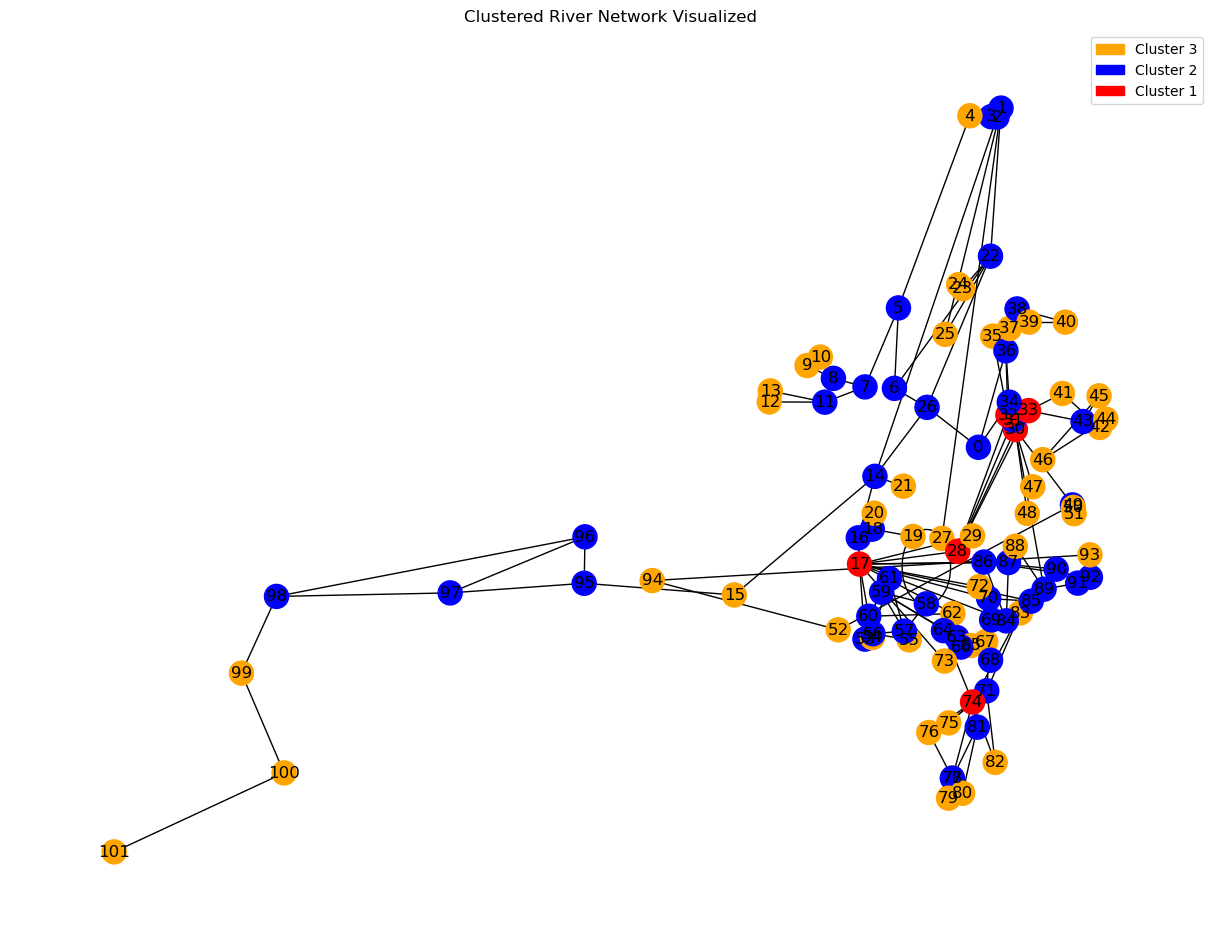

In [42]:
###Draw the network based on location and cluster
cluster_colors = {1 : 'red', 2 : 'blue', 3 : 'orange'}
plt.figure(figsize = (12, 9))
nx.draw(River_System, positions, node_color = River_df['Cluster Groupings'].map(cluster_colors), with_labels = True)
plt.title('Clustered River Network Visualized')
red_patch = mpatches.Patch(color='orange', label='Cluster 3')
blue_patch = mpatches.Patch(color='blue', label='Cluster 2')
orange = mpatches.Patch(color='red', label='Cluster 1')


plt.legend(handles = [red_patch, blue_patch, orange])
plt.show()



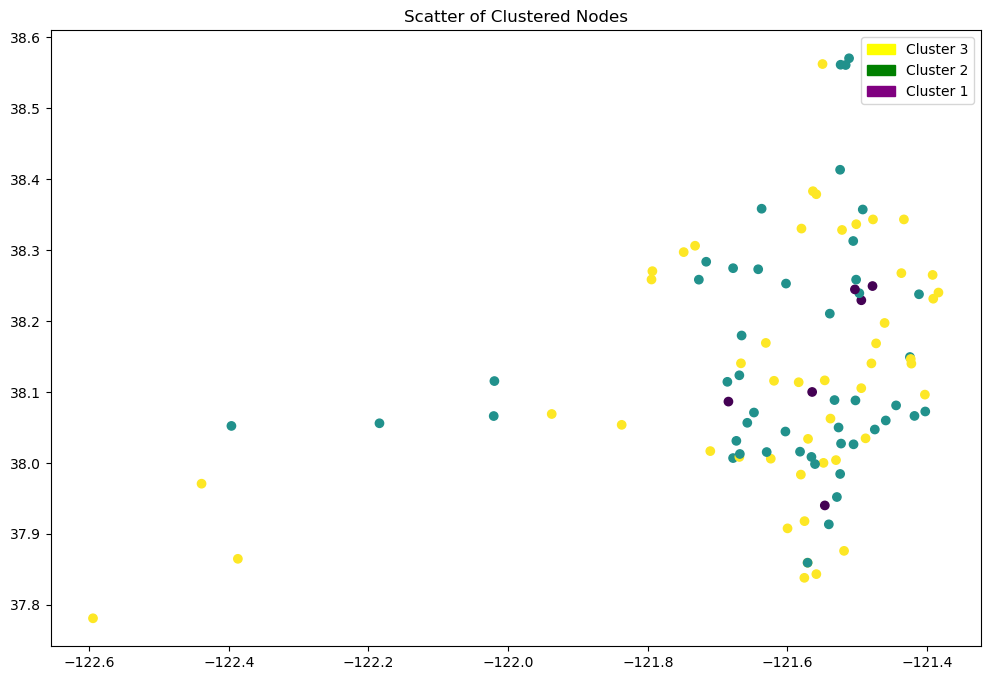

In [43]:
plt.figure(figsize=(12,8))
plt.scatter(data = River_df, x = 'Longitude(West)', y = 'Latitude(North)', c = "Cluster Groupings")
plt.title("Scatter of Clustered Nodes")
red_patch = mpatches.Patch(color='yellow', label='Cluster 3')
blue_patch = mpatches.Patch(color='green', label='Cluster 2')
orange = mpatches.Patch(color='purple', label='Cluster 1')


plt.legend(handles = [red_patch, blue_patch, orange])
plt.show()

In [44]:
tidy_df = River_df_tocluster.copy()
#tidy_df = tidy_df.set_index("Cluster Groupings")
#tidy_df = tidy_df.stack()
#tidy_df.index.names = ['cluster0', 'cluster1', 'cluster2', 'cluster3']
#tidy_df = tidy_df.rename(columns={0:'Attributes'})
tidy_df

,betweenness,closeness_centrality,degree_centrality,Node Degree,Cluster Groupings
NodeID,,,,,
1,0.093312,0.204868,0.049505,5,2
2,0.020066,0.199211,0.029703,3,2
3,0.030957,0.180357,0.029703,3,2
4,0.016601,0.159306,0.019802,2,3
5,0.132574,0.158307,0.029703,3,2
...,...,...,...,...,...
98,0.038020,0.142053,0.029703,3,2
99,0.058218,0.125622,0.029703,3,2
100,0.039208,0.112222,0.019802,2,3


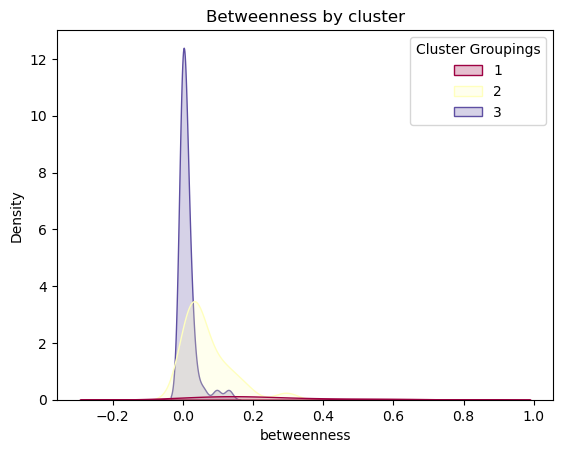

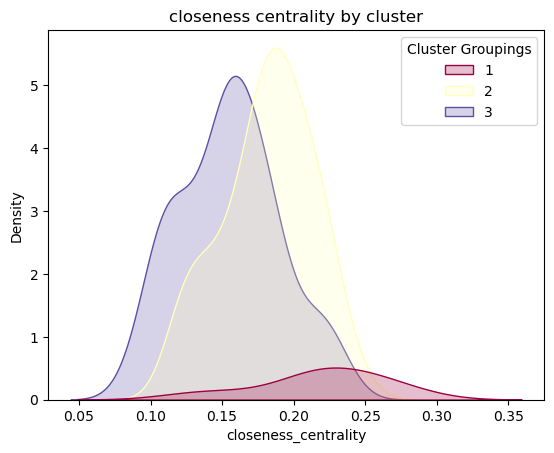

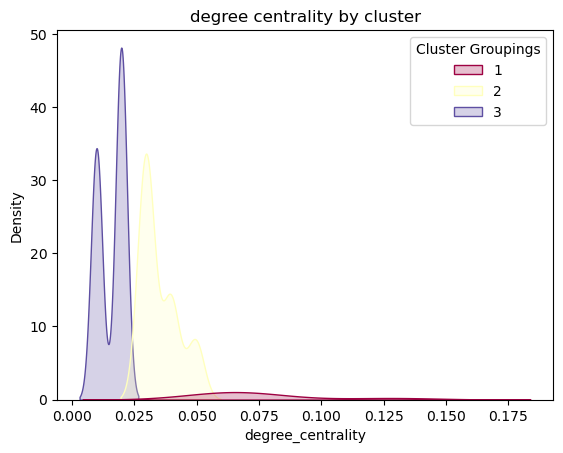

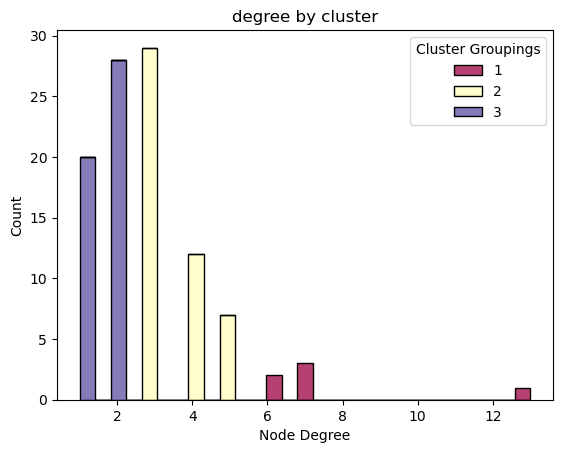

In [45]:
sns.kdeplot(data = tidy_df, x = 'betweenness', hue = 'Cluster Groupings', shade = True, palette= "Spectral")
plt.title("Betweenness by cluster")
plt.show()
sns.kdeplot(data = tidy_df, x = 'closeness_centrality', hue = 'Cluster Groupings', shade = True, palette= "Spectral")
plt.title("closeness centrality by cluster")
plt.show()
sns.kdeplot(data = tidy_df, x = 'degree_centrality', hue = 'Cluster Groupings', shade = True, palette= "Spectral")
plt.title("degree centrality by cluster")
plt.show()
sns.histplot(data = tidy_df, x = 'Node Degree', hue = 'Cluster Groupings', palette= "Spectral", multiple='stack')
plt.title("degree by cluster")
plt.show()

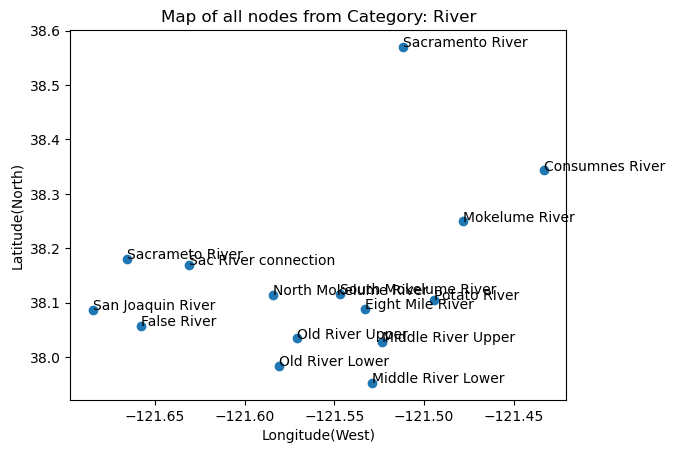

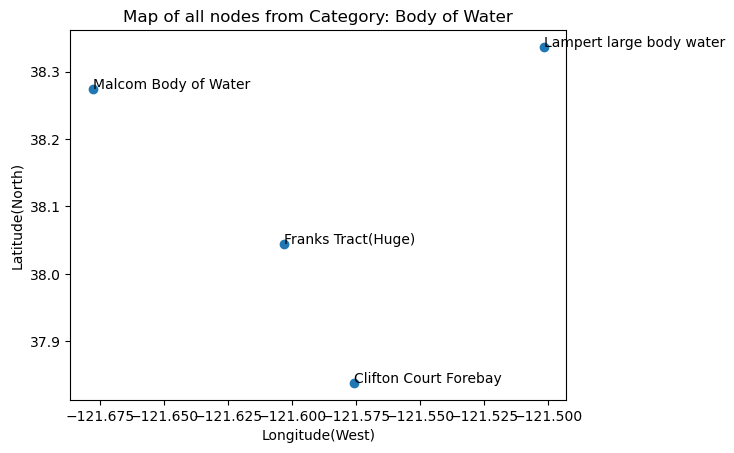

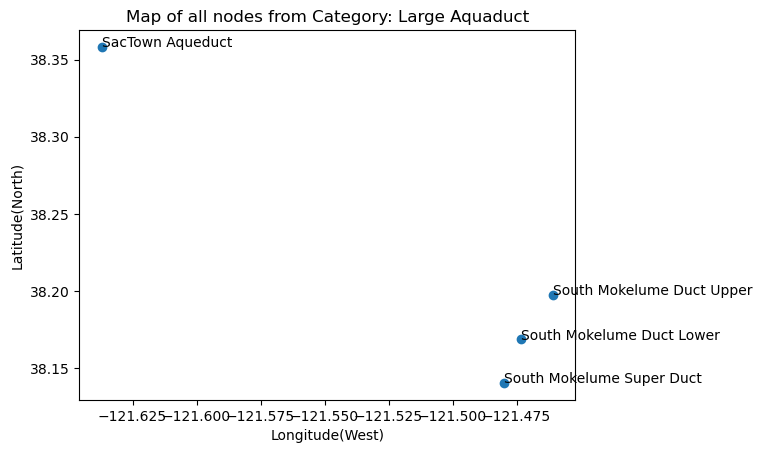

Category 3 has no data
Category 4 has no data
Category 5 has no data


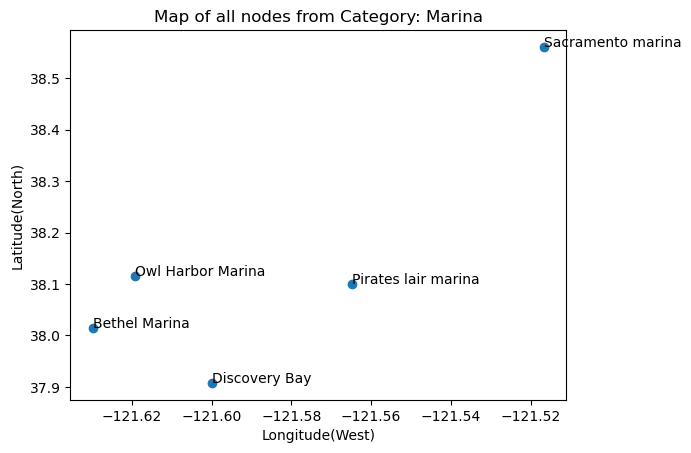

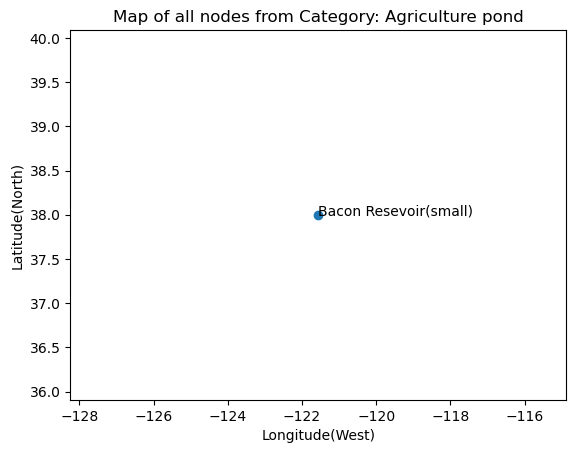

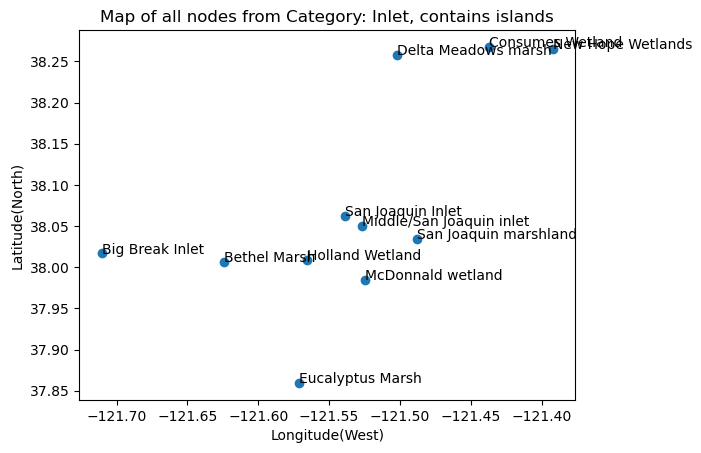

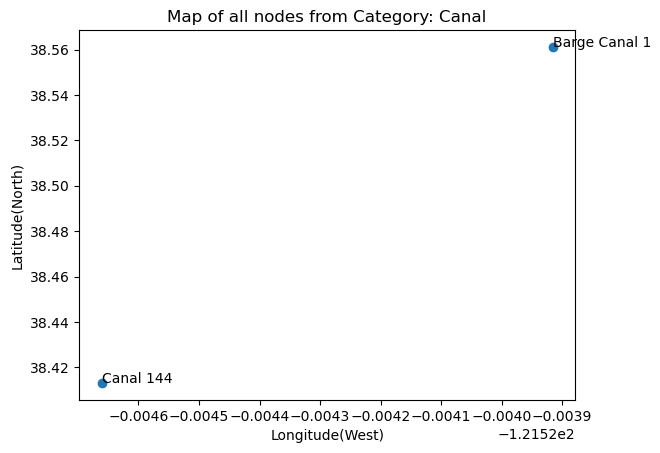

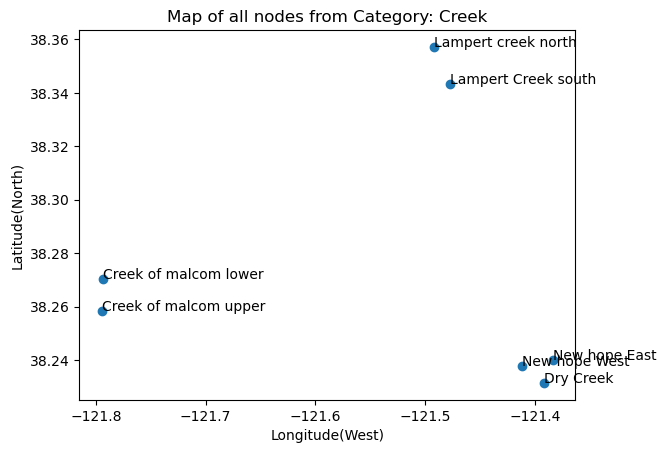

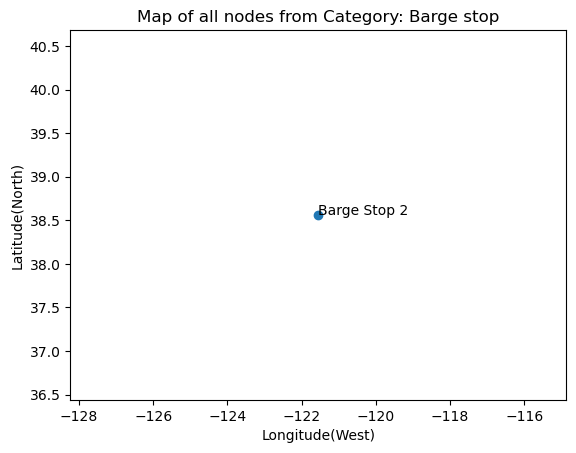

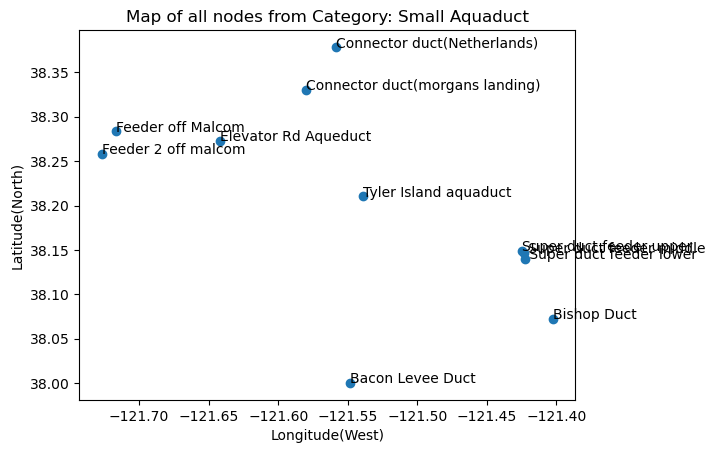

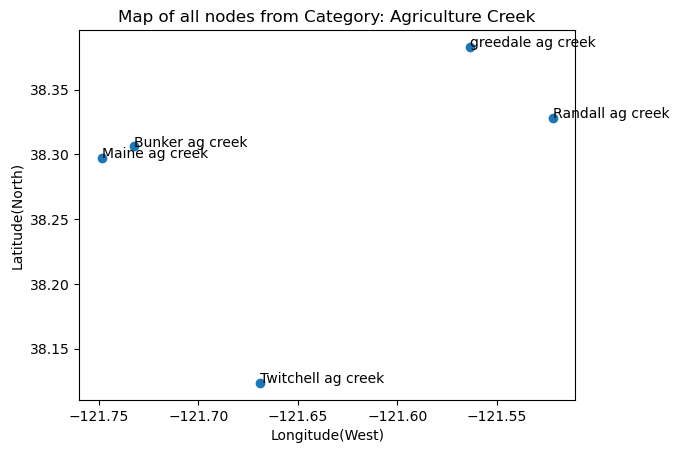

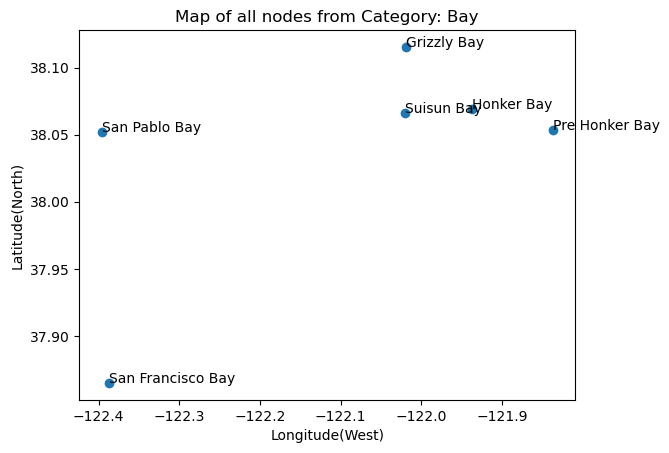

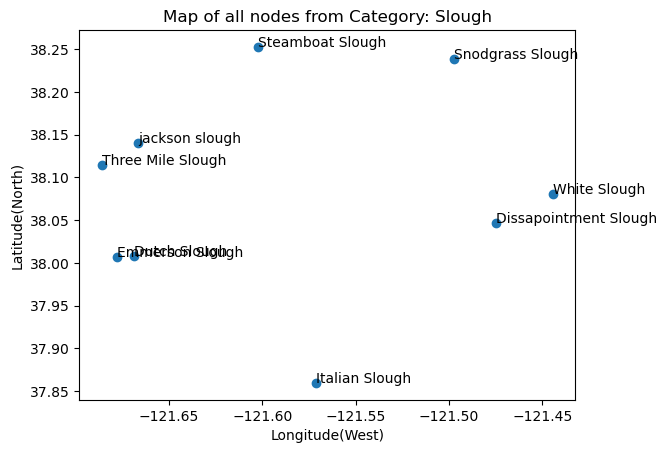

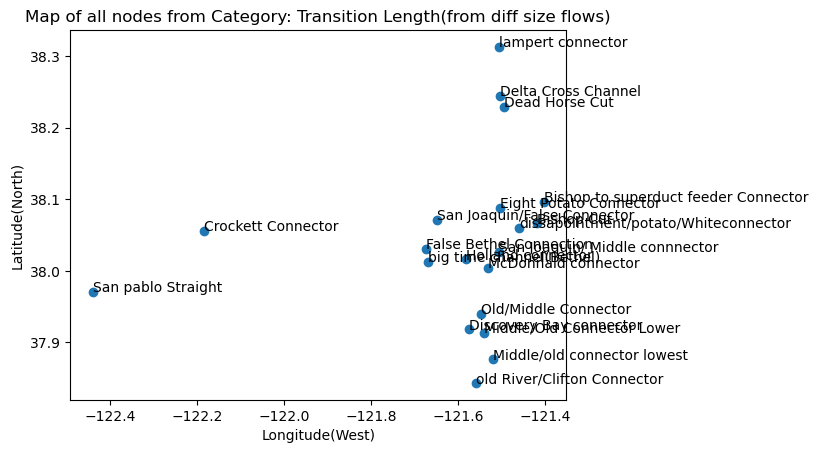

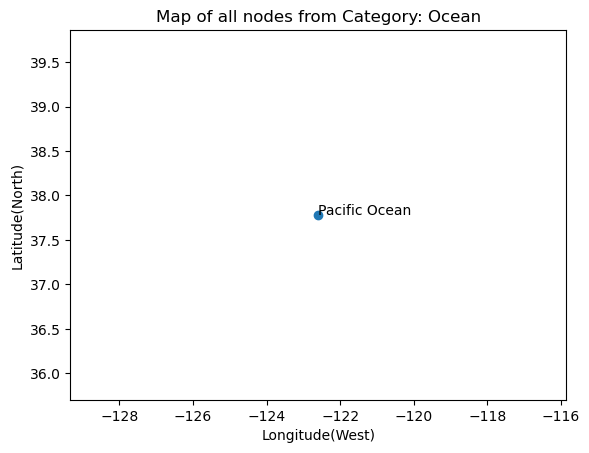

In [46]:
for index,category_df in enumerate(dfs_by_cat):
    if len(category_df) == 0:
        print(f'Category {index} has no data')
    else:
        plt.scatter(category_df['Longitude(West)'],category_df['Latitude(North)'])
        plt.title(f'Map of all nodes from Category: {categories_dict.get(str(index))}')
        plt.xlabel('Longitude(West)')
        plt.ylabel('Latitude(North)')
        for i in range(len(category_df)):
            plt.annotate(category_df["Name:"][i], (category_df['Longitude(West)'][i],category_df['Latitude(North)'][i]))
        plt.show()

In [47]:
map_hubs = folium.Map()
for i in range(len(hubs_df)):
    folium.Marker([np.array(hubs_df['Latitude(North)'])[i], 
                np.array(hubs_df['Longitude(West)'])[i]], 
                popup = np.array(hubs_df['Name:'])[i]).add_to(map_hubs)
folium.TileLayer('Stamen Terrain').add_to(map_hubs)
folium.TileLayer('Stamen Toner').add_to(map_hubs)
folium.TileLayer('Stamen Water Color').add_to(map_hubs)
folium.TileLayer('cartodbpositron').add_to(map_hubs)
folium.TileLayer('cartodbdark_matter').add_to(map_hubs)
folium.LayerControl().add_to(map_hubs)
map_hubs


In [49]:
map_all = folium.Map()
for i in range(len(River_df)):
    folium.Marker([np.array(River_df['Latitude(North)'])[i], 
                   np.array(River_df['Longitude(West)'])[i]], 
                   popup = np.array(River_df['Name:'])[i]).add_to(map_all)
folium.TileLayer('Stamen Terrain').add_to(map_all)
folium.TileLayer('Stamen Toner').add_to(map_all)
folium.TileLayer('Stamen Water Color').add_to(map_all)
folium.TileLayer('cartodbpositron').add_to(map_all)
folium.TileLayer('cartodbdark_matter').add_to(map_all)
folium.LayerControl().add_to(map_all)

map_all.save(outfile = "map_of_nodes.html")
map_html = map_all._repr_html_()
print(map_html)

# map_all

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe srcdoc="&lt;!DOCTYPE html&gt;
&lt;html&gt;
&lt;head&gt;
    
    &lt;meta http-equiv=&quot;content-type&quot; content=&quot;text/html; charset=UTF-8&quot; /&gt;
    
        &lt;script&gt;
            L_NO_TOUCH = false;
            L_DISABLE_3D = false;
        &lt;/script&gt;
    
    &lt;style&gt;html, body {width: 100%;height: 100%;margin: 0;padding: 0;}&lt;/style&gt;
    &lt;style&gt;#map {position:absolute;top:0;bottom:0;right:0;left:0;}&lt;/style&gt;
    &lt;script src=&quot;https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js&quot;&gt;&lt;/script&gt;
    &lt;script src=&quot;https://code.jquery.com/jquery-1.12.4.min.js&quot;&gt;&lt;/script&gt;
    &lt;script src=&quot;https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js&quot;&gt;&lt;/script&gt;
    &l

In [50]:
def main():
    map_all = folium.Map()
    for i in range(len(River_df)):
        folium.Marker([np.array(River_df['Latitude(North)'])[i], 
                   np.array(River_df['Longitude(West)'])[i]], 
                   popup = np.array(River_df['Name:'])[i]).add_to(map_all)
    folium.TileLayer('Stamen Terrain').add_to(map_all)
    folium.TileLayer('Stamen Toner').add_to(map_all)
    folium.TileLayer('Stamen Water Color').add_to(map_all)
    folium.TileLayer('cartodbpositron').add_to(map_all)
    folium.TileLayer('cartodbdark_matter').add_to(map_all)
    folium.LayerControl().add_to(map_all)
    map_html = map_all._repr_html_()
    print(map_html)
    return {'map': map_html}



In [59]:
River_df

,NaN,Latitude(North),Longitude(West),Neighbors,Category,Name:,Other Categories:,"Lat,Long",Node Degree,betweenness,degree_centrality,closeness_centrality,Cluster Groupings
NodeID,,,,,,,,,,,,,
1,NaN,38.570258,-121.511848,"[2, 3]",0,Sacramento River,NaN,"(-121.5118481, 38.5702579)",5,0.093312,0.049505,0.204868,2
2,NaN,38.560765,-121.516698,"[1, 3]",6,Sacramento marina,NaN,"(-121.5166983, 38.56076507)",3,0.020066,0.029703,0.199211,2
3,NaN,38.561169,-121.523916,"[2, 1]",9,Barge Canal 1,NaN,"(-121.5239158, 38.5611691)",3,0.030957,0.029703,0.180357,2
4,NaN,38.562139,-121.549840,"[3, 5]",11,Barge Stop 2,NaN,"(-121.5498401, 38.5621388)",2,0.016601,0.019802,0.159306,3
5,NaN,38.358281,-121.637045,"[4, 6, 7]",2,SacTown Aqueduct,NaN,"(-121.6370446, 38.3582813)",3,0.132574,0.029703,0.158307,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,NaN,38.055937,-122.184262,"[97, 96, 99]",16,Crockett Connector,NaN,"(-122.1842615, 38.0559374)",3,0.038020,0.029703,0.142053,2
99,NaN,38.052206,-122.396258,[98],14,San Pablo Bay,NaN,"(-122.3962584, 38.0522062)",3,0.058218,0.029703,0.125622,2
100,NaN,37.970805,-122.439030,"[99, 101]",16,San pablo Straight,NaN,"(-122.4390299, 37.9708048)",2,0.039208,0.019802,0.112222,3


I would like to find best way to create edge vertex matrix!!!!!

In [60]:
# vertex_edge_matrix = [[0]*River_System.number_of_edges()]*102

In [80]:
# adj_matrix = nx.adj_matrix(River_System)
graph_to_nparray = nx.to_numpy_array(River_System)
graph_to_npmatrix = nx.to_numpy_matrix(River_System)

In [79]:
# print('the shape of adj matrix is:', np.shape(adj_matrix))
print('the shape of the numpy array from network x is', np.shape(graph_to_nparray))
print('the shape of the to_numpy_matrix is:', np.shape(graph_to_npmatrix))
# So what seems to be the case is that the adj matrix and the to_numpy_array deliver the same result, but obviously numpy just easier to work with.


the shape of the numpy array from network x is (102, 102)
the shape of the to_numpy_matrix is: (102, 102)


Ok so in the folowing cells we now plot our networks as an adjacency matrix

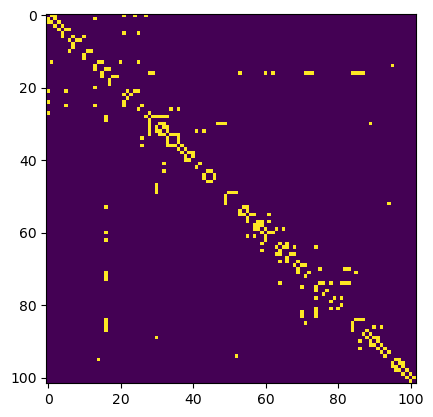

In [75]:
plt.imshow(graph_to_nparray)

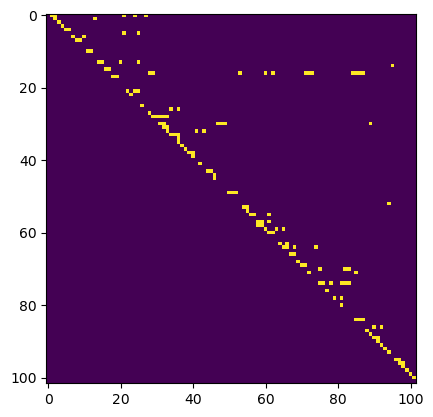

In [78]:
plt.imshow(np.triu(graph_to_npmatrix))